In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [6]:
class ResetMcl(Mcl):
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.01, "on":0.13, "oo":0.2},
                distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001):
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold =alpha_threshold
    
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs):
        psi = np.random.uniform(-np.pi, np.pi)
        ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs()
        particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
        particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
        
        phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs()
        particle.pose[2] = math.atan2(landmark_pos[1] - particle.pose[1], landmark_pos[0] - particle.pose[0]) - phi
        
        particle.weight = 1.0/len(self.particles)
    
    def sensor_resetting(self, observation):
        nearest_obs = np.argmin([obs[0][0] for obs in observation])
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
    
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev)
        
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation)
        else:
            self.resampling()

<IPython.core.display.Javascript object>


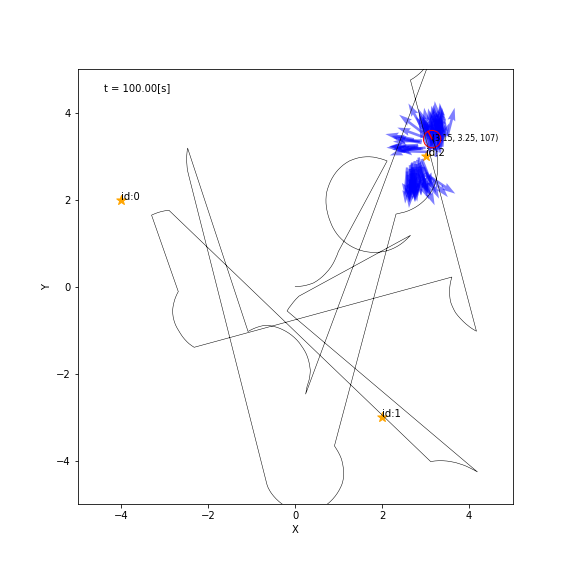

In [9]:
if __name__ == "__main__":
    time_interval = 0.1
    world = World(100, time_interval, debug=False)

    m = Map()
    for ln in [(-4, 2), (2, -3), (3, 3)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)

    initial_pose = np.array([0, 0, 0]).T
    pf = ResetMcl(m, initial_pose, 100)
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(initial_pose, sensor=Camera(m), agent=circling, expected_kidnap_time=10.0, color="red")
    world.append(r)

    world.draw()